Reading mask
Filename: /home/zgd/cmb_y/ver1/unWISE/loss/unmaskedareafrac-flag.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (50331648,)   float64   
None
Making galaxy map 1


/tmp/ipykernel_3594/3168255281.py:96: RuntimeWarning: invalid value encountered in divide
  numcounts_map = numcounts_map / mask_lost


1.0309643820680994


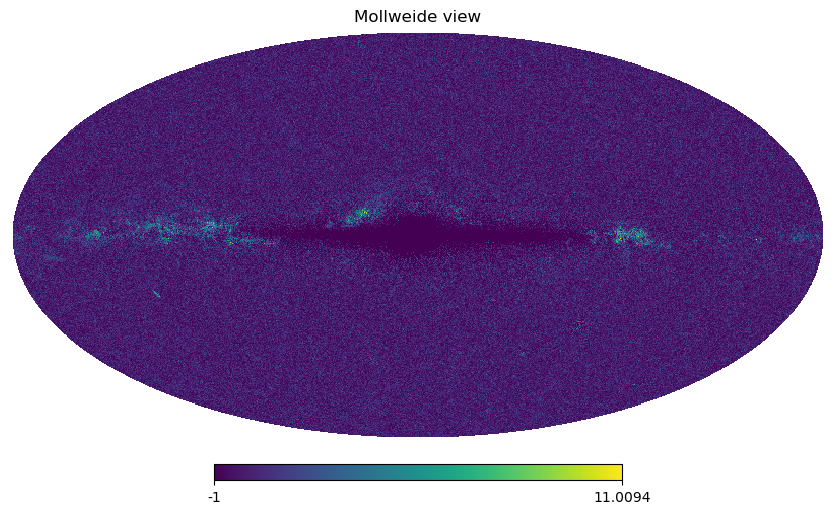

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as pl
import sys
from astropy.io import fits

# SAMPLE   (0: bright), (1: blue), (2: green), (3: red full), (4: red W2 < 16.6), (5: kappa_CMB), (6: kappa_CMB, tSZ free), (7: red W2 < 16.2), (8: red W2 < 16.5)

sample1 = 1
sample2 = 1

if sample1 == 5 or sample1 == 6:
    print('Please make the CMB lensing map the second argument')
    sys.exit()

#HEALPix map resolution
nside = 2048

PATH = '/global/homes/s/sferraro/maps/unWISE/'

########################################
### READING RAW MAPS PATH
########################################

def read_path(sample):
    if sample == 5:
        map_name = PATH + 'PLANCK_LENSING/COM_Lensing_4096_R3.00/MV/dat_klm.fits'
    elif sample == 6:
        map_name = PATH + 'PLANCK_LENSING/COM_Lensing_Szdeproj_4096_R3.00/TT/dat_klm.fits' # tSZ deprojected 2018 lensing map (TT only)
    elif sample == 4:
        map_name = PATH + 'current_maps/numcounts_map3_2048-r1_w2lt166flag.fits'    # Red but brighter W2 < 16.6
    elif sample == 7:
        map_name = PATH + 'current_maps/numcounts_map3_2048-r1_w2lt162flag.fits'    # Red but brighter W2 < 16.2
    elif sample == 8:
        map_name = PATH + 'current_maps/numcounts_map3_2048-r1_w2lt165flag.fits'    # Red but brighter W2 < 16.5
    elif sample == 9:
        map_name = PATH + 'star_maps/gaiastarmap.fits'
    elif sample == 10:
        map_name = PATH + 'blue_stars.fits'
    elif sample == 11:
        map_name = PATH + 'green_stars.fits'
    elif sample == 12:
        map_name = PATH + 'red_stars.fits'
    else:
        map_name = '/home/zgd/cmb_y/ver1/unWISE/blue/numcounts_map1_2048-r1-v2_flag.fits'
    return map_name


########################################
### READING MASK AND APODIZE
########################################

#mask_name = PATH + 'MASKS/sdss_mask.fits'     # Mask already apodized

print('Reading mask')
mask = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/mask/mask_unWISE_full_v10.fits')
#mask = hp.ud_grade(hp.read_map(mask_name, verbose=False),2048)*mask_default


#hp.mollview(mask)
#pl.show()

lost = fits.open('/home/zgd/cmb_y/ver1/unWISE/loss/unmaskedareafrac-flag.fits')
print(lost.info())
mask_lost = lost[0].data

########################################
### MAKING MAPS
########################################

#   First field
weight1 = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/weights/blue_w2_5sig_weights.fits')
weight2 = hp.read_map('/home/zgd/cmb_y/ver1/unWISE/weights/blue_star_weights.fits')
weights = hp.ud_grade(weight1*weight2,2048)


def makemap(sample):
    if (sample == 5) or (sample == 6):
        print('Making lensing map')
        kappa_map_alm = hp.read_alm(read_path(sample))
        map = hp.alm2map(kappa_map_alm, nside)
        # Note that namaster autmatically multiplies by the mask compute_full_master
        # I verify this in test_namaster.py (using Eiichiro Komatsu's MASTER code for mask deconvolution)
    elif sample >= 9:
        #numcounts_map = hp.read_map(read_path(sample))
        numcounts_map = fits.open(read_path(sample))[0].data
        masked_count = numcounts_map * mask
        mean_count = np.nansum(masked_count)/np.nansum(mask)
        masked_count_dn = numcounts_map / mean_count - 1.
        map = masked_count_dn
    else:
        # Converting the masked number counts to delta_n/n. Only consider unmasked regions!
        print('Making galaxy map ' + str(sample))
        numcounts_map = hp.read_map(read_path(sample), field=[0]) * weights
        # Correct for lower density in regions of high area lost due to stars or stellar masking
        numcounts_map = numcounts_map / mask_lost
        masked_count = numcounts_map * mask
        mean_count = np.nansum(masked_count) / np.nansum(mask)
        masked_count_dn = numcounts_map / mean_count - 1.
        
        map = masked_count_dn
        map[mask_lost == 0] = 0
        std_map = np.sqrt( np.sum(map**2) / np.sum(mask) )
        print (std_map)
        hp.mollview(map)
        #pl.show()
    return map

map1 = makemap(sample1)


In [2]:
print('Reading Planck mask')
mask_pl = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits',field=1)
lfi_bool = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/LFI_inpainting_bool.fits')
hfi_bool = hp.read_map('/home/zgd/cmb_y/ver1/Planck/mask/HFI_inpainting_bool.fits')

ymask = mask_pl * lfi_bool * hfi_bool

fsky = np.sum(ymask * mask)/len(mask)

ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_CIBdT_default_standard_full.fits')

clgy = hp.anafast(ymap * ymask, map1 * mask)/fsky

clgy_binned_cmb_cib_dbeta_dt = np.mean(clgy[:6000].reshape((120,50)),axis=1)

ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_standard_full.fits')

clgy = hp.anafast(ymap * ymask, map1 * mask)/fsky

clgy_binned_def = np.mean(clgy[:6000].reshape((120,50)),axis=1)

ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits')

clgy = hp.anafast(ymap * ymask, map1 * mask)/fsky

clgy_binned_cmb_cib = np.mean(clgy[:6000].reshape((120,50)),axis=1)

ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/no_deprojection_standard_full.fits')

clgy = hp.anafast(ymap * ymask, map1 * mask)/fsky

clgy_binned_no = np.mean(clgy[:6000].reshape((120,50)),axis=1)

ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_CIBdT_default_standard_full.fits')

galcut_mask = np.ones_like(mask)
lon, lat = hp.pix2ang(2048,np.arange(len(galcut_mask)),lonlat=True)
galcut_mask[np.abs(lat) < 60] = 0
fsky_new = np.sum(ymask * mask * galcut_mask)/len(mask)
clgy = hp.anafast(ymap * ymask, map1 * mask, gal_cut=60)/fsky_new

clgy_binned_cmb_cib_dbeta_dt_galcut_60 = np.mean(clgy[:6000].reshape((120,50)),axis=1)

Reading Planck mask


In [6]:
ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T24_standard_full.fits')

clgy = hp.anafast(ymap * ymask, map1 * mask)/fsky

clgy_binned_cmb_cib_beta1_6_T24 = np.mean(clgy[:6000].reshape((120,50)),axis=1)

In [15]:
ymap = hp.read_map('/home/zgd/cmb_y/ver1/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits')

clgy = hp.anafast(ymap * ymask * mask, map1 * ymask * mask)/fsky

clgy_binned_cmb_cib_dbeta_dt_overmasked = np.mean(clgy[:6000].reshape((120,50)),axis=1)

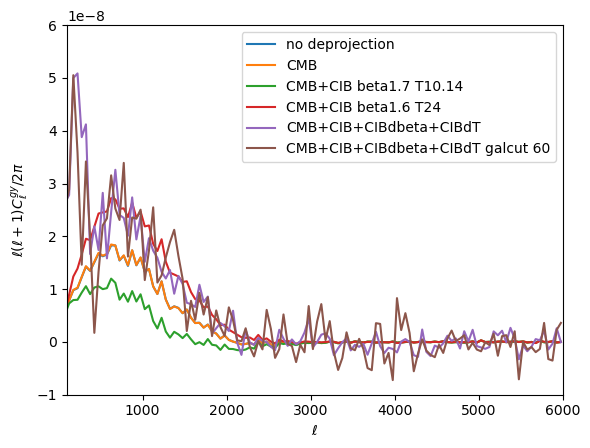

In [17]:
ll=np.arange(120)*50+25

pl.plot(ll,(ll+1)*ll*clgy_binned_no/(2*np.pi),label='no deprojection')
pl.plot(ll,(ll+1)*ll*clgy_binned_def/(2*np.pi),label='CMB')
pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib/(2*np.pi),label='CMB+CIB beta1.7 T10.14')
pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib_beta1_6_T24/(2*np.pi),label='CMB+CIB beta1.6 T24')
pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib_dbeta_dt/(2*np.pi),label='CMB+CIB+CIBdbeta+CIBdT')
pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib_dbeta_dt_galcut_60/(2*np.pi),label='CMB+CIB+CIBdbeta+CIBdT galcut 60')
#pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib_dbeta_dt_overmasked/(2*np.pi),label='CMB+CIB+CIBdbeta+CIBdT overmasked')
pl.xlim(100,6000)
pl.ylim(-0.1E-7,0.6E-7)
pl.ylabel('$\ell(\ell+1)C_\ell^{gy}/2\pi$')
pl.xlabel('$\ell$')
pl.legend()
pl.savefig('./output/corr/clgy.png',dpi=400)


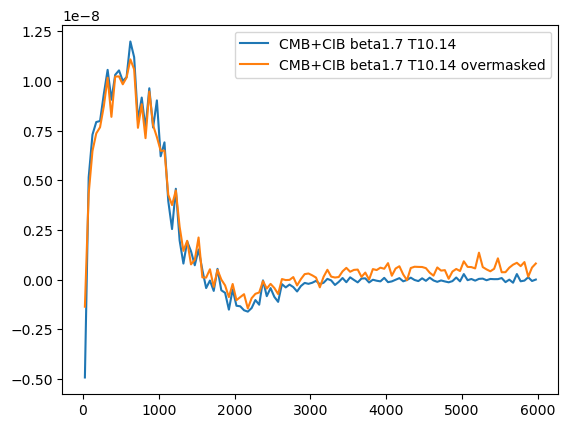

In [19]:
pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib/(2*np.pi),label='CMB+CIB beta1.7 T10.14')
pl.plot(ll,(ll+1)*ll*clgy_binned_cmb_cib_dbeta_dt_overmasked/(2*np.pi),label='CMB+CIB beta1.7 T10.14 overmasked')
pl.legend()
pl.savefig('./output/corr/clgy_overmasked.png',dpi=400)